In [212]:
import pickle
import warnings
import random
import umap
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance, KDTree
from scipy import stats
from sklearn import decomposition
from IPython.display import display, Markdown
from itertools import product

from torch.nn import functional as F

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [6]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [7]:
embeds, rows = [], []

titles = set()

for path in tqdm(glob('../data/clean-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            
            title = ' '.join(line.pop('tokens'))
            
            if title not in titles:
                embeds.append(line.pop('embedding'))
                rows.append(OrderedDict(title=title, **line))
                titles.add(title)

100%|██████████| 66/66 [00:24<00:00,  2.64it/s]


In [8]:
embeds = np.stack(embeds)

In [9]:
df = pd.DataFrame(rows)

In [10]:
df.label.unique()

array(['dailycaller.com', 'bloomberg.com', 'thehill.com',
       'huffingtonpost.com', 'dailykos.com', 'nytimes.com', 'cnn.com',
       'wsj.com', 'apnews.com', 'breitbart.com', 'foxnews.com',
       'washingtonpost.com', 'buzzfeed.com'], dtype=object)

In [11]:
embeds.shape

(642151, 512)

In [177]:
def plot_ptrue_perf(pdf, pcol='p_true'):
    
    count_cdf = np.cumsum(pdf['count'].sort_values(ascending=False)) / pdf['count'].sum()
    pdf['count_cdf'] = count_cdf.sort_index()
    
    xs = [pdf[pdf.count_cdf>0.5][pcol], pdf[pdf.count_cdf<0.5][pcol]]
    labels = ['Low reach', 'High reach']

    plt.figure(figsize=(5,3))
    ys, x, _ = plt.hist(xs, histtype='step', bins=50, linewidth=2, label=labels, normed=True)
    plt.legend()
    plt.show()
    
    return stats.ttest_ind(xs[1], xs[0], equal_var=False)

# Sounds like self

dailycaller.com


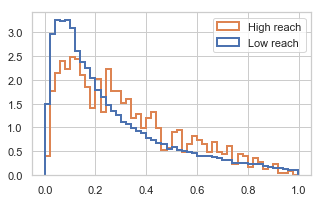

Ttest_indResult(statistic=8.331183073426976, pvalue=2.0410074241895851e-16) 

bloomberg.com


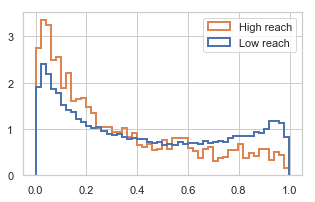

Ttest_indResult(statistic=-18.101580561916464, pvalue=1.792708569055567e-68) 

thehill.com


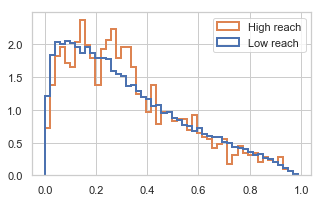

Ttest_indResult(statistic=0.4303961082721167, pvalue=0.6669666130746871) 

huffingtonpost.com


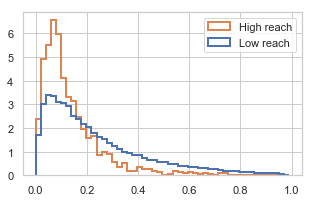

Ttest_indResult(statistic=-27.539958339979474, pvalue=5.487941873390027e-134) 

dailykos.com


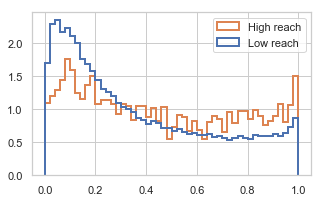

Ttest_indResult(statistic=16.16579841605188, pvalue=1.294244986011518e-56) 

nytimes.com


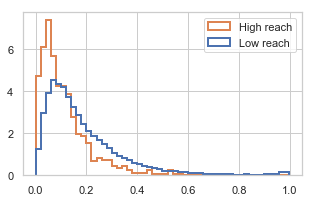

Ttest_indResult(statistic=-19.770917121073033, pvalue=4.309826855519167e-73) 

cnn.com


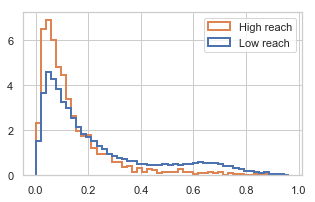

Ttest_indResult(statistic=-24.78969892395919, pvalue=9.027219591394592e-113) 

wsj.com


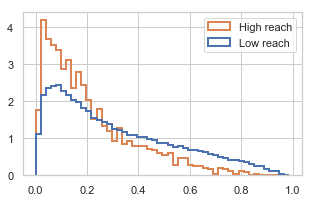

Ttest_indResult(statistic=-20.617570212803827, pvalue=1.2889450894320439e-82) 

apnews.com


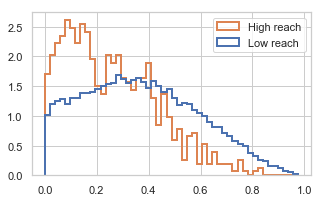

Ttest_indResult(statistic=-17.47848584216561, pvalue=2.0634364446055638e-58) 

breitbart.com


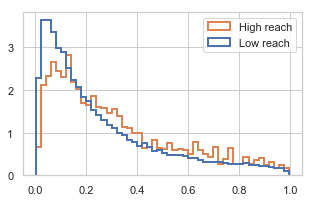

Ttest_indResult(statistic=12.530789685630186, pvalue=3.6117749963388244e-35) 

foxnews.com


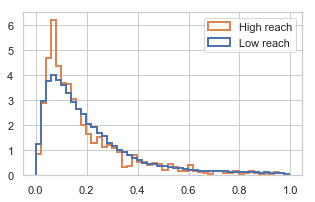

Ttest_indResult(statistic=-3.7109953878744246, pvalue=0.00021599384826839142) 

washingtonpost.com


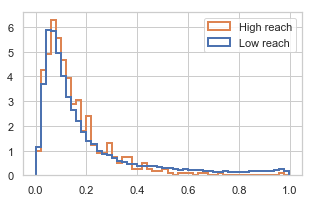

Ttest_indResult(statistic=-10.206644588277037, pvalue=7.779903719001085e-23) 

buzzfeed.com


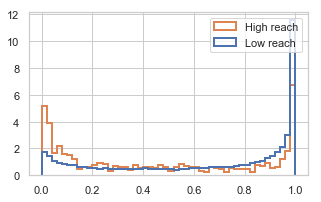

Ttest_indResult(statistic=-14.715980897522885, pvalue=1.6270656639710494e-43) 



In [194]:
rows = []
for d in df.label.unique():
    print(d)
    tt = plot_ptrue_perf(df[df.label==d])
    print(tt, '\n')
    rows.append((d, tt.statistic, tt.pvalue))

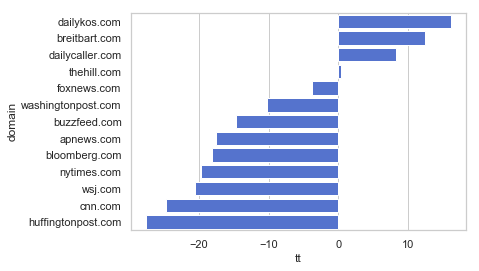

In [198]:
pdf = pd.DataFrame(rows, columns=('domain', 'tt', 'p'))
pdf.sort_values('tt', ascending=False, inplace=True)
sns.barplot(x='tt', y='domain', data=pdf, color='RoyalBlue')

# Sounds like Breitbart

dailycaller.com


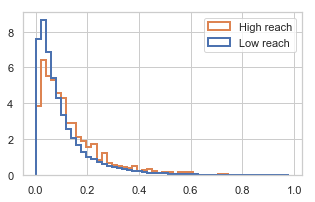

Ttest_indResult(statistic=8.748665056100977, pvalue=6.774591051027789e-18) 

bloomberg.com


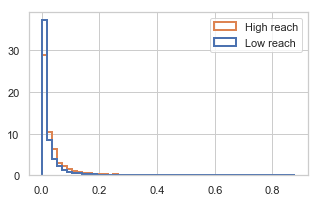

Ttest_indResult(statistic=9.09729141110719, pvalue=2.070657377942931e-19) 

thehill.com


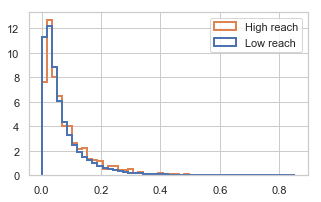

Ttest_indResult(statistic=5.327173039389146, pvalue=1.1445898076508756e-07) 

huffingtonpost.com


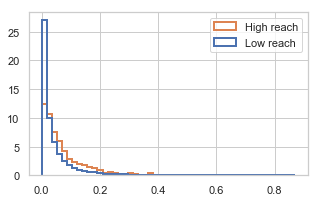

Ttest_indResult(statistic=12.255639846748217, pvalue=9.891421237627344e-33) 

dailykos.com


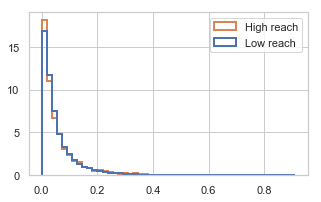

Ttest_indResult(statistic=0.1782392452108343, pvalue=0.858546031539763) 

nytimes.com


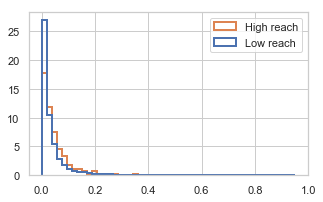

Ttest_indResult(statistic=6.242276423110364, pvalue=6.626432939296398e-10) 

cnn.com


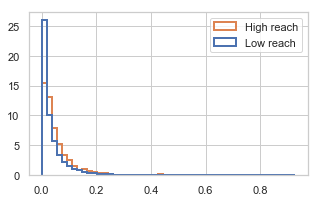

Ttest_indResult(statistic=7.780747522431558, pvalue=1.470447106906599e-14) 

wsj.com


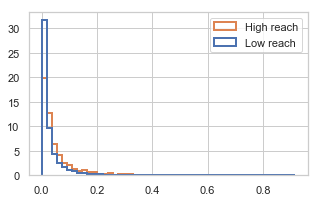

Ttest_indResult(statistic=9.627019418551289, pvalue=3.0382701873923363e-21) 

apnews.com


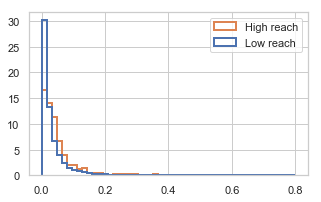

Ttest_indResult(statistic=7.981150148987512, pvalue=5.0327053115603035e-15) 

breitbart.com


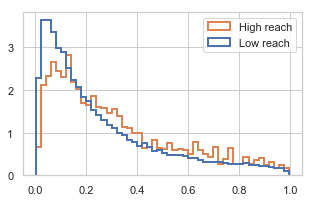

Ttest_indResult(statistic=12.530789685630186, pvalue=3.6117749963388244e-35) 

foxnews.com


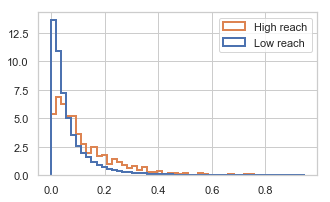

Ttest_indResult(statistic=14.482606695269148, pvalue=8.311536291225024e-44) 

washingtonpost.com


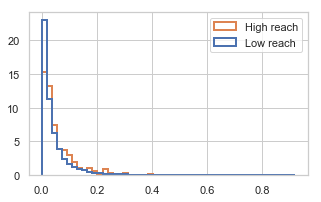

Ttest_indResult(statistic=4.1512815958698575, pvalue=3.754966565797276e-05) 

buzzfeed.com


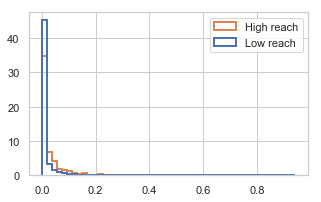

Ttest_indResult(statistic=8.001153513150259, pvalue=4.439835906219387e-15) 



In [199]:
rows = []
for d in df.label.unique():
    print(d)
    tt = plot_ptrue_perf(df[df.label==d], 'p_breitbart.com')
    print(tt, '\n')
    rows.append((d, tt.statistic, tt.pvalue))

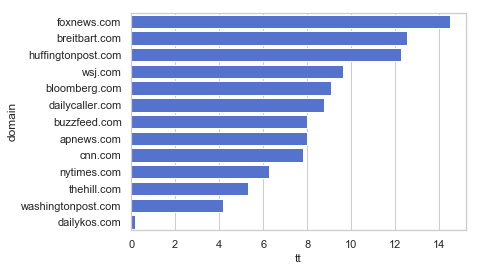

In [200]:
pdf = pd.DataFrame(rows, columns=('domain', 'tt', 'p'))
pdf.sort_values('tt', ascending=False, inplace=True)
sns.barplot(x='tt', y='domain', data=pdf, color='RoyalBlue')

# Sounds like NYT

dailycaller.com


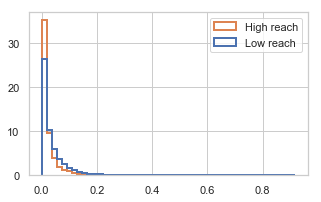

Ttest_indResult(statistic=-15.054300413124015, pvalue=1.8354076462914945e-47) 

bloomberg.com


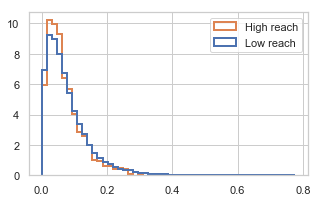

Ttest_indResult(statistic=-2.7932033032790584, pvalue=0.005263842142485692) 

thehill.com


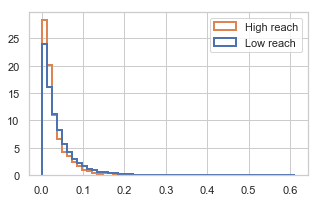

Ttest_indResult(statistic=-8.936443524741662, pvalue=1.0742484444174752e-18) 

huffingtonpost.com


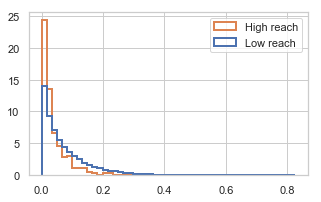

Ttest_indResult(statistic=-26.328804330307037, pvalue=5.00953904655862e-125) 

dailykos.com


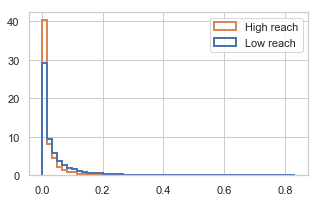

Ttest_indResult(statistic=-27.58464617795835, pvalue=2.070040192464724e-153) 

nytimes.com


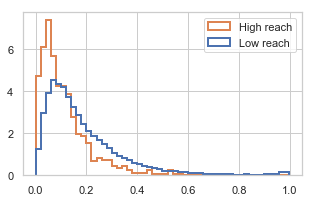

Ttest_indResult(statistic=-19.770917121073033, pvalue=4.309826855519167e-73) 

cnn.com


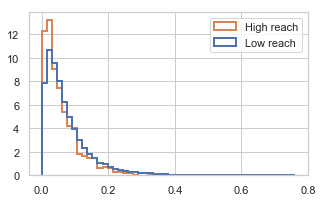

Ttest_indResult(statistic=-7.363863017431582, pvalue=3.1462192989825736e-13) 

wsj.com


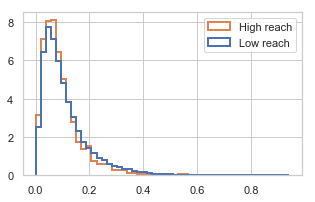

Ttest_indResult(statistic=-6.3923163861523475, pvalue=2.2388333692183853e-10) 

apnews.com


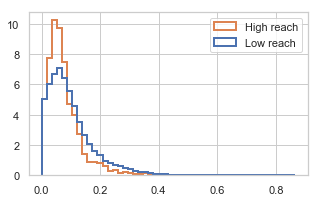

Ttest_indResult(statistic=-11.19311977121874, pvalue=3.417125299063677e-27) 

breitbart.com


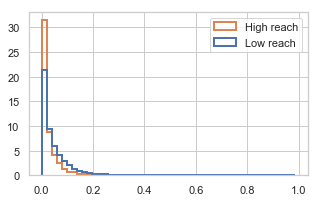

Ttest_indResult(statistic=-28.596739718563818, pvalue=2.1496315558451861e-162) 

foxnews.com


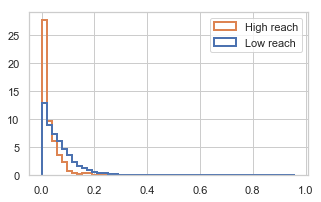

Ttest_indResult(statistic=-29.73941317095312, pvalue=3.0187187768114087e-148) 

washingtonpost.com


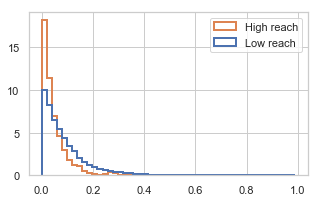

Ttest_indResult(statistic=-14.906470871041982, pvalue=1.7771227066749571e-43) 

buzzfeed.com


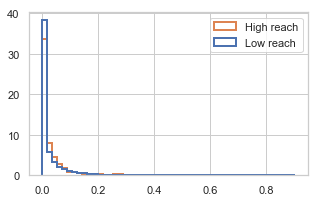

Ttest_indResult(statistic=2.6983537663318335, pvalue=0.007116095095587531) 



In [201]:
rows = []
for d in df.label.unique():
    print(d)
    tt = plot_ptrue_perf(df[df.label==d], 'p_nytimes.com')
    print(tt, '\n')
    rows.append((d, tt.statistic, tt.pvalue))

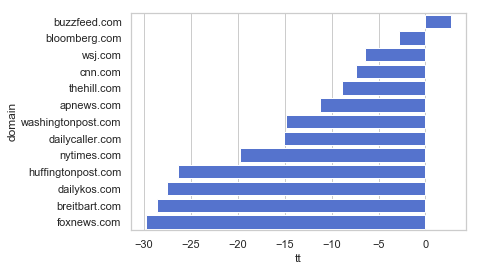

In [202]:
pdf = pd.DataFrame(rows, columns=('domain', 'tt', 'p'))
pdf.sort_values('tt', ascending=False, inplace=True)
sns.barplot(x='tt', y='domain', data=pdf, color='RoyalBlue')

In [208]:
def sl_ttest(d1, d2, threshold=0.5):
    
    ddf = df[df.label==d1]
    pkey = f'p_{d2}'
    
    count_cdf = np.cumsum(ddf['count'].sort_values(ascending=False)) / ddf['count'].sum()
    ddf['count_cdf'] = count_cdf.sort_index()

    pt_hr = ddf[ddf.count_cdf<threshold][pkey]
    pt_lr = ddf[ddf.count_cdf>threshold][pkey]
    
    return stats.ttest_ind(pt_hr, pt_lr, equal_var=False)

In [211]:
sl_ttest('foxnews.com', 'cnn.com')

Ttest_indResult(statistic=-11.804228680316998, pvalue=1.5608842074366095e-30)

In [213]:
domains = df.label.unique()

In [216]:
rows = []
for d1, d2 in tqdm(product(domains, domains)):
    tt = sl_ttest(d1, d2)
    rows.append((d1, d2, tt.statistic, tt.pvalue))

169it [03:53,  1.34s/it]


In [226]:
pdf = pd.DataFrame(rows, columns=('d1', 'd2', 'tt', 'p'))
pdf['label'] = pdf[['d1', 'd2']].apply(lambda x: f'{x[0]} -> {x[1]}', axis=1)
pdf.sort_values('tt', ascending=False, inplace=True)

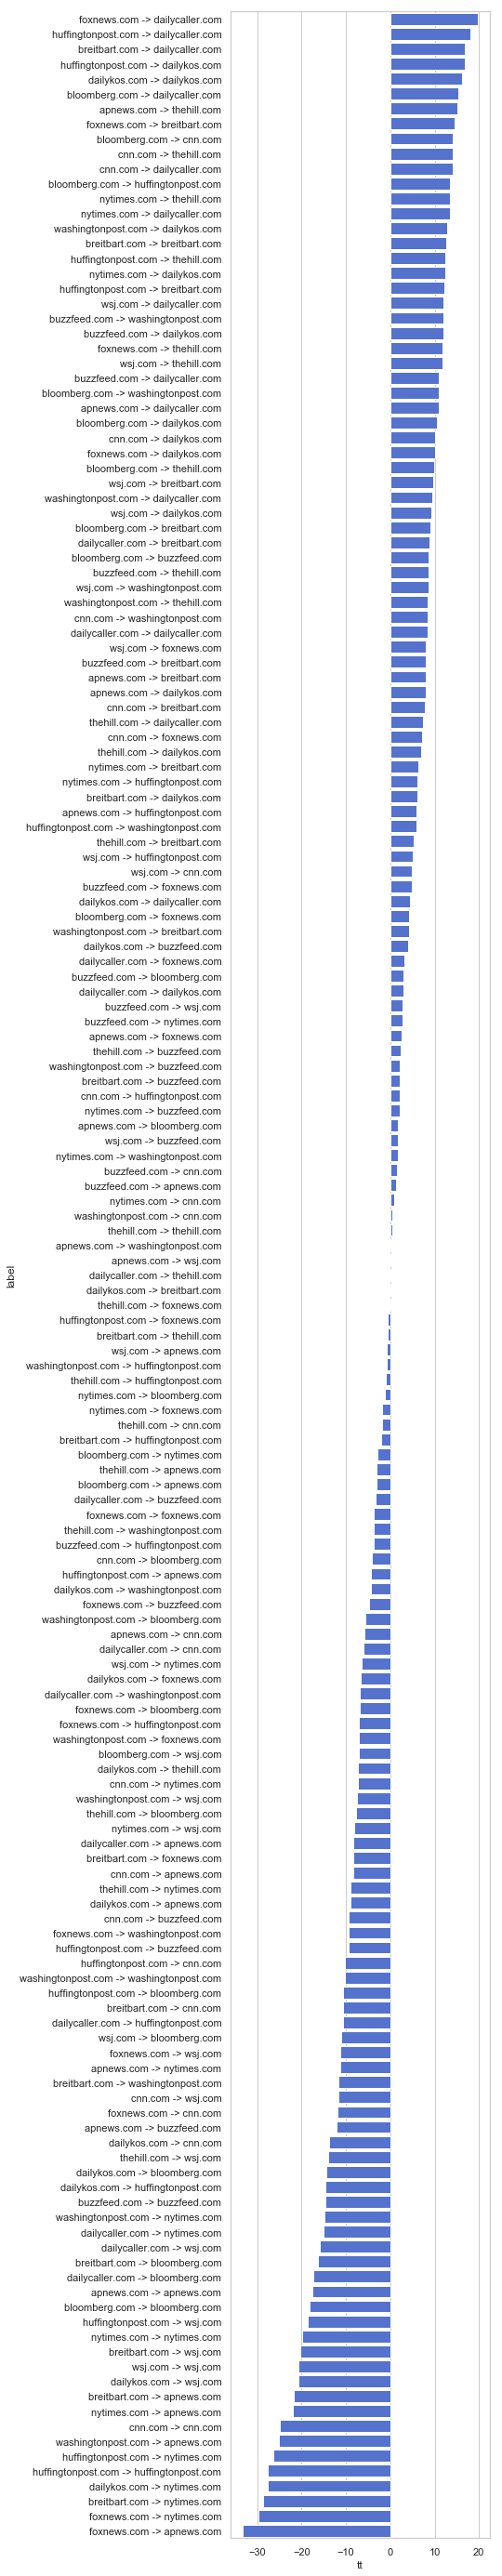

In [227]:
plt.figure(figsize=(5,50))
sns.barplot(x='tt', y='label', data=pdf, color='RoyalBlue')

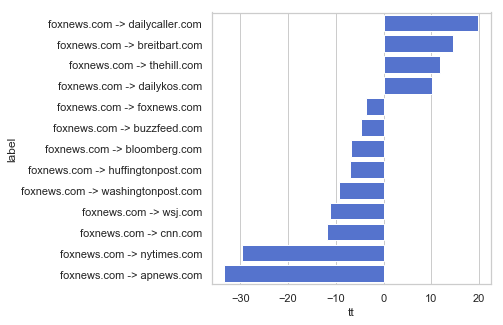

In [232]:
plt.figure(figsize=(5,5))
sns.barplot(x='tt', y='label', data=pdf[pdf.d1=='foxnews.com'], color='RoyalBlue')

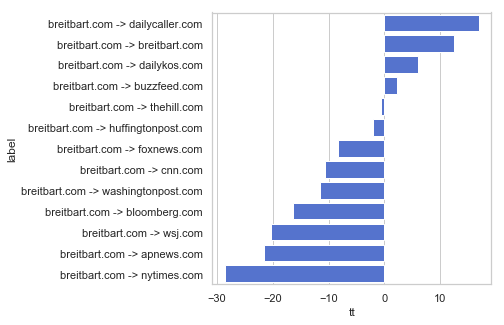

In [233]:
plt.figure(figsize=(5,5))
sns.barplot(x='tt', y='label', data=pdf[pdf.d1=='breitbart.com'], color='RoyalBlue')

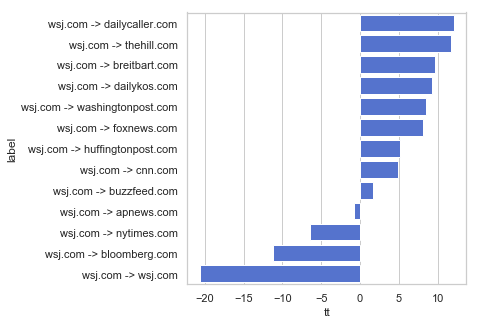

In [234]:
plt.figure(figsize=(5,5))
sns.barplot(x='tt', y='label', data=pdf[pdf.d1=='wsj.com'], color='RoyalBlue')

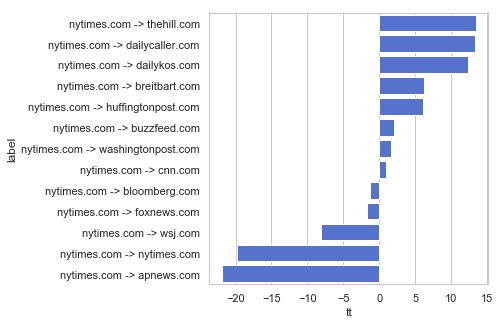

In [235]:
plt.figure(figsize=(5,5))
sns.barplot(x='tt', y='label', data=pdf[pdf.d1=='nytimes.com'], color='RoyalBlue')